<a href="https://colab.research.google.com/github/VintageGold/Text_Summarization/blob/main/Sentiment_analysis_W2v_co_occurrency_tsne_Word_cloud_Kmeans_Text_similarity_liang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import json
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from  vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from google.colab import drive
drive.mount('/content/gdrive')
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.mode.chained_assignment = None 

import nltk
nltk.download('stopwords')

from gensim.models import word2vec

from sklearn.manifold import TSNE
STOP_WORDS = nltk.corpus.stopwords.words()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
!pip install vaderSentiment

## Load Data

In [119]:
df = pd.read_csv('/content/gdrive/My Drive/Text_Summarization/processed/Telehealth.csv')

## Sentiment analysis

### Use VaderSentiment to get the polarity of the sentiment analysis.

In [132]:
import nltk
nltk.download('vader_lexicon')
def vader_sentiment_scores(text): 
    SIA_obj = SentimentIntensityAnalyzer() 
    # calculate polarity scores which gives a sentiment dictionary, 
    # Contains pos, neg, neu, and compound scores. 
    polarity_dict = SIA_obj.polarity_scores(text) 
    # Calculate overall sentiment by compound score
    if polarity_dict['compound'] >= 0.05 : 
        return "Positive"
  
    elif polarity_dict['compound'] <= - 0.05 : 
        return "Negative"
    else : 
        return "Neutral"
for i in range(len(df)) :
    sentiment_single = vader_sentiment_scores(df.loc[i, "Clean_Content"])
    df.loc[i, "Sentiments"] = sentiment_single
df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,LongForm,LongForm_Clean_Content,LongForm_Clean_Content_length,LongForm_Clean_Content_Stopwords,LongForm_Clean_Content_Stopwords_Lemma,Clean_Content,Classification,Sentiments
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"['telepsychology,', 'meta-analysis,', 'veteran...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,Veterans face a variety of stressors related t...,43903,Veterans face variety stressors related times ...,veteran face variety stressor relate time loca...,veteran face variety stressor relate time loca...,Covid,Negative
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"['remote', 'child', 'custody', 'evaluations,',...",10,Forensic Psychology,48,The impact of the coronavirus disease 2019 pan...,The impact of the coronavirus disease 2019 pan...,90181,The impact coronavirus disease 2019 pandemic c...,the impact coronavirus disease 2019 pandemic c...,the impact coronavirus disease 2019 pandemic c...,Covid,Positive
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"['forensic', 'e-mental', 'health,', 'telehealt...",8,Forensic Psychology,128,"In November 2019, coronavirus disease 2019—the...",In November 2019 coronavirus disease 2019—the ...,72051,In November 2019 coronavirus disease 2019—the ...,in November 2019 coronavirus disease 2019 — th...,in November 2019 coronavirus disease 2019 — th...,Covid,Positive
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"['education', 'and', 'training,', 'telepsychol...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,Anxiety and depressive disorders are among the...,35085,Anxiety depressive disorders common impairing ...,anxiety depressive disorder common impair ment...,anxiety depressive disorder common impair ment...,Covid,Positive
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"['remote', 'psychotherapy,', 'Covid-19,', 'pan...",6,Clinical & Counseling Psychology,14,"In mid-March, 2020, the authors—as well as the...",In mid-March 2020 the authors—as well as the m...,48376,In mid-March 2020 authors—as majority therapis...,in mid - March 2020 author — as majority thera...,in mid - March 2020 author — as majority thera...,Covid,Positive


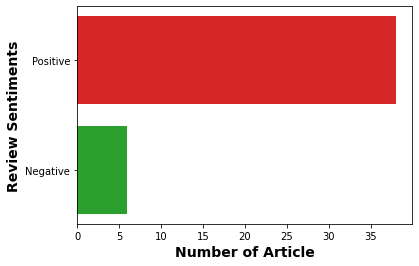

In [115]:
Sentiment_count=df.groupby('Sentiments').count()
plt.barh(Sentiment_count.index.values, Sentiment_count['Article Title'], color=['C2', 'C3', 'C4'])
plt.ylabel('Review Sentiments',fontweight= 'bold', fontsize = '14')
plt.xlabel('Number of Article', fontweight= 'bold', fontsize = '14')
plt.show()

###Use TextBlob to analysis polarity and subjectivity of sentiment analysis.

In [116]:
# Create new df columns based on Polarity and Subjectivity of the texts.
from textblob import TextBlob
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
df['Polarity'] = df['Clean_Content'].apply(pol)
df['Subjectivity'] = df['Clean_Content'].apply(sub)
df.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Stopwords_Lemma_Longform_Clean_Content,Clean_Content,Classification,Sentiments,Polarity,Subjectivity
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"['telepsychology,', 'meta-analysis,', 'veteran...",5,Clinical & Counseling Psychology,50,veteran face variety stressor relate military ...,veteran face variety stressor relate military ...,Covid,Negative,0.035342,0.365054
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"['remote', 'child', 'custody', 'evaluations,',...",10,Forensic Psychology,48,impact coronavirus disease 2019 pandemic child...,impact coronavirus disease 2019 pandemic child...,Covid,Positive,0.080288,0.432254
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"['forensic', 'e-mental', 'health,', 'telehealt...",8,Forensic Psychology,128,November 2019 coronavirus disease 2019 infecti...,November 2019 coronavirus disease 2019 infecti...,Covid,Positive,0.008845,0.364340
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"['education', 'and', 'training,', 'telepsychol...",6,Clinical & Counseling Psychology,21,anxiety depressive disorder common impair ment...,anxiety depressive disorder common impair ment...,Covid,Positive,0.086982,0.454477
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"['remote', 'psychotherapy,', 'Covid-19,', 'pan...",6,Clinical & Counseling Psychology,14,mid March 2020 author majority therapist advis...,mid March 2020 author majority therapist advis...,Covid,Positive,0.083345,0.474921


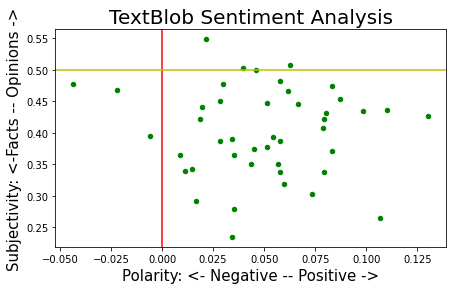

In [117]:
import matplotlib.pyplot as plt

df.plot.scatter(x ='Polarity', y ='Subjectivity', color = 'green', figsize =[7, 4])    
plt.title('TextBlob Sentiment Analysis', fontsize=20)
plt.xlabel('Polarity: <- Negative -- Positive ->', fontsize=15)
plt.ylabel('Subjectivity: <-Facts -- Opinions ->', fontsize=15)
plt.axvline(0.0, color = 'r')
plt.axhline(0.5, color = 'y')
    
plt.show()


#### Pre_Covid and Covid count

In [13]:
grouped=df.groupby(['Classification','Sentiments']).Content.count()
grouped

Classification  Sentiments
Covid           Negative       5
                Positive      24
Pre-Covid       Negative       1
                Positive      14
Name: Content, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5fec5f450>,
      dtype=object)

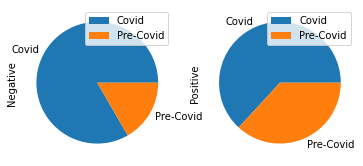

In [21]:
df.groupby(['Classification','Sentiments']).Content.count().unstack().plot(kind='pie',subplots=True).legend(loc='right')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5f044df50>,
      dtype=object)

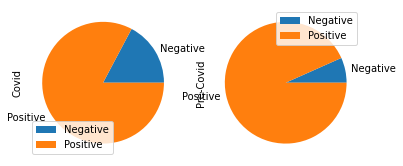

In [23]:
df.groupby(['Sentiments','Classification']).Content.count().unstack().plot(kind='pie',subplots=True)

## TF-IDF transformation

## Generate document term matrix by using scikit-learn's CountVectorizer.

In [180]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.corpus import stopwords
from nltk import word_tokenize
token= RegexpTokenizer(r'\w+')

cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize )
text_counts= cv.fit_transform(df['Clean_Content'])
#print(cv.vocabulary_)

### Multinomial Naive Bayes model
#### Countervectorezie and TF-IDF vectorzation accuary comparasion.

In [46]:
# Transform a count matrix to a normalized  tf-idf representation
# tf-idf(Term Frequency - Inverse Document-Frequency ) helps to know the most significant words in a document
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(text_counts)
print(tfidf_transformer,"\n")

reviews_tfidf = tfidf_transformer.transform(text_counts)
#print(reviews_tfidf)
print(reviews_tfidf.shape)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True) 



In [175]:
# Multinomial Naive Bayes Algorithm – It is used to classify on words occurrence.
### Let's split dataset  for TF-IDF vectorization. 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
reviews_tfidf, df['Sentiments'], test_size=0.3, random_state=300)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.8571428571428571


In [176]:
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(df['Sentiments'], all_predictions )

print(classification_report(df['Sentiments'], all_predictions))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         6
    Positive       0.86      1.00      0.93        38

    accuracy                           0.86        44
   macro avg       0.43      0.50      0.46        44
weighted avg       0.75      0.86      0.80        44



In [174]:
### Let's split dataset  for CountVectorizerized. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['Sentiments'], test_size=0.3, random_state=300)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.8571428571428571


## Word2Vec Co_occurrence Tsne 

In [33]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['Clean_Content', 'Abstract','Parsed_Keywords']:
      for sentence in data['Clean_Content']:
        word_list = sentence.split(" ")
        corpus.append(word_list)
            
    return corpus

corpus = build_corpus(df)        

### Tsne_plot
#### Overview

In [35]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


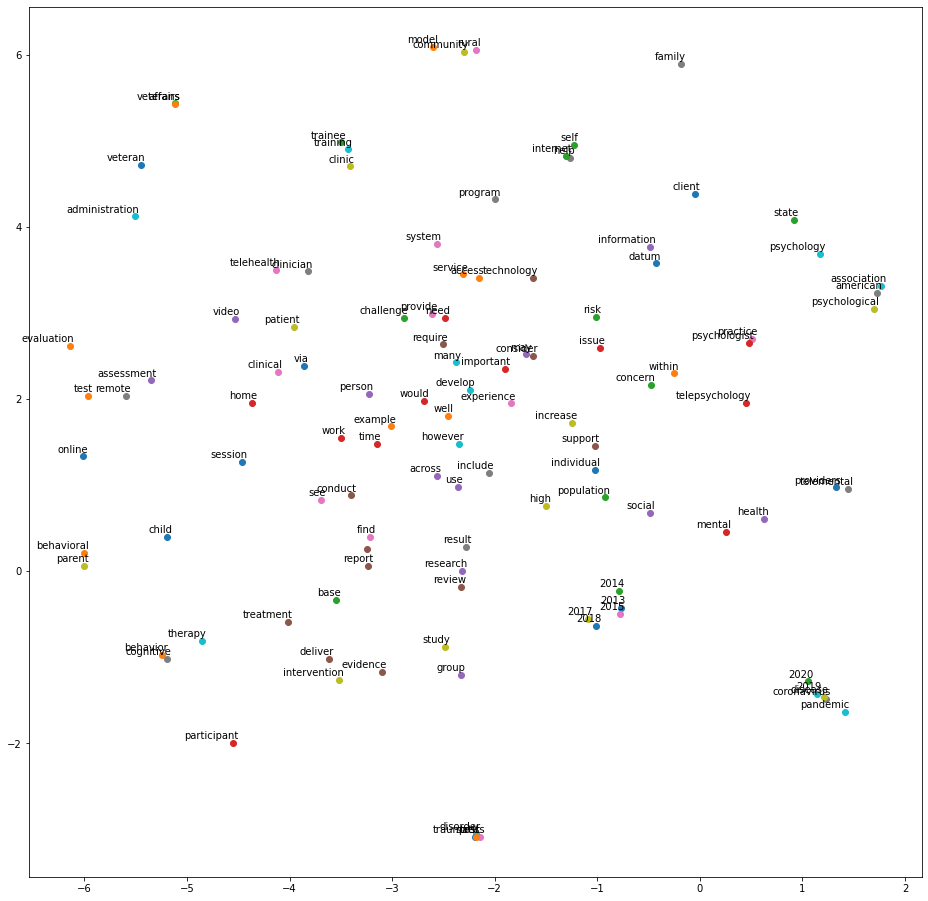

In [49]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=600, workers=4)
tsne_plot(model)

In [160]:
semantically_similar_words = {words: [item[0] for item in model.most_similar([words], topn=5)] 
                              for words in ['coronavirus', 'telemental', 'health', 'therapy', 'network', 'psychological', '2019','2020']}
for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

coronavirus:['2019', 'disease', 'pandemic', 'crisis', '2020']
telemental:['v', 'providers', 'health', 'hub', 'provider']
health:['care', 'mental', 'providers', 'primary', 'telemental']
therapy:['cognitive', 'behavior', 'trauma', 'treatment', 'therapist']
network:['facilitate', 'local', 'speak', 'create', 'resource']
psychological:['american', 'association', 'guideline', 'code', 'ethical']
2019:['coronavirus', 'disease', '2020', 'crisis', 'pandemic']
2020:['2019', 'coronavirus', 'disease', 'world', 'hilty']


#### Pre-Covid and Covid analysis 
##### Pre-Covid

In [91]:
Pre_Covid_df = df[df['Classification']=="Pre-Covid"]

In [92]:
#Pre_Covid_df = df[df['Classification']=="Pre-Covid"]
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    #for col in ['Clean_Content', 'Abstract','Parsed_Keywords']:
    for sentence in data['Clean_Content']:
        word_list = sentence.split(" ")
        corpus.append(word_list)
            
    return corpus

Pre_Covid_corpus = build_corpus(Pre_Covid_df)
#Pre_Covid_model = word2vec.Word2Vec(Pre_Covid_corpus, window=20, min_count=200, workers=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


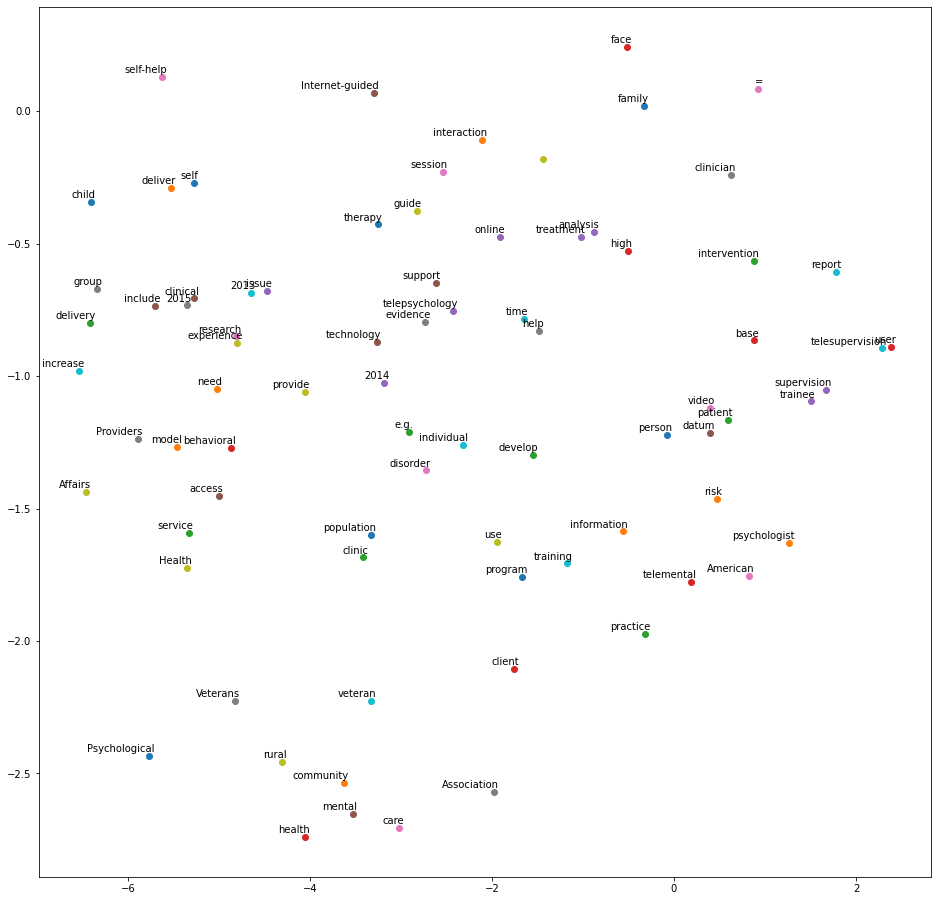

In [95]:
def tsne_plot(Pre_Covid_model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in Pre_Covid_model.wv.vocab:
        tokens.append(Pre_Covid_model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
Pre_Covid_model = word2vec.Word2Vec(Pre_Covid_corpus, window=20, min_count=80, workers=4)
tsne_plot(Pre_Covid_model)

##### Covid

In [96]:
Covid_df = df[df['Classification']=="Covid"]
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    #for col in ['Clean_Content', 'Abstract','Parsed_Keywords']:
    for sentence in data['Clean_Content']:
        word_list = sentence.split()
        corpus.append(word_list)
            
    return corpus
Covid_corpus = build_corpus(Covid_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


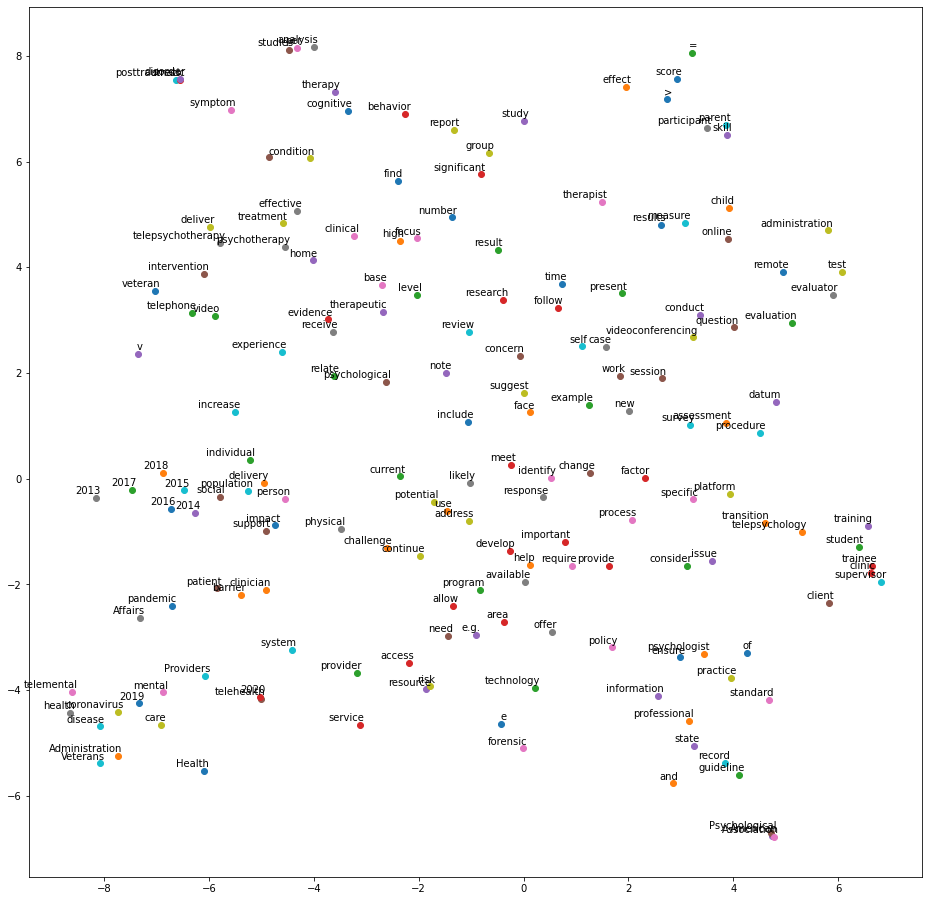

In [98]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    #for col in ['Clean_Content', 'Abstract','Parsed_Keywords']:
    for sentence in data['Clean_Content']:
        word_list = sentence.split(" ")
        corpus.append(word_list)
            
    return corpus
Covid_corpus = build_corpus(Covid_df)

def tsne_plot(Covid_model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in Covid_model.wv.vocab:
        tokens.append(Covid_model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
Covid_model = word2vec.Word2Vec(Covid_corpus, window=20, min_count=100, workers=4)
tsne_plot(Covid_model)

## Kmeans to determine clustering optimal number.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(df['Clean_Content'])

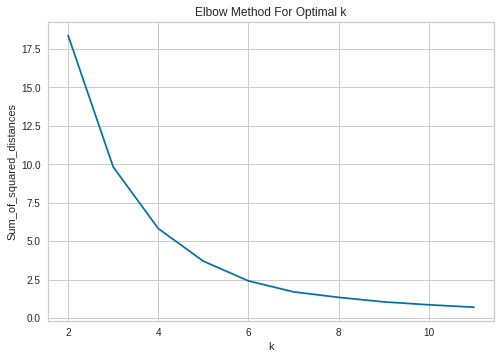

In [41]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,12)
for k in K:
  km = KMeans(n_clusters=k, max_iter=200, n_init=10)
  km = km.fit(X.reshape(-1,1))
  Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## key topic 

In [177]:
import numpy as np
from sklearn.decomposition import NMF
idx_to_word = np.array(cv.get_feature_names())

nmf = NMF(n_components=20, solver="mu")
W = nmf.fit_transform(text_counts)
H = nmf.components_
# print the topics
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word [topic.argsort()[-10:]]])))

Topic 1: increase,g,need,service,e,telemental,use,mental,care,health
Topic 2: report,study,pandemic,face,participant,result,psychologist,practice,use,telepsychology
Topic 3: assessment,datum,interview,parent,videoconferencing,custody,use,evaluator,evaluation,child
Topic 4: information,healtht,technology,american,service,practice,association,psychological,psychologist,client
Topic 5: provide,care,service,risk,program,user,internet,self,help,guide
Topic 6: provider,article,include,analysis,attitude,study,patient,providers,telemental,v
Topic 7: disease,2019,transition,provide,supervisor,service,client,trainee,training,clinic
Topic 8: telehealth,site,clinical,service,veteran,psychologist,affairs,hub,telemental,veterans
Topic 9: use,administration,coronavirus,disease,patient,2020,pandemic,2019,video,care
Topic 10: clinical,session,telepsychotherapy,posttraumatic,cognitive,disorder,base,stress,therapy,treatment
Topic 11: stress,depression,treatment,size,effect,disorder,veteran,deliver,analys

### word cloud
#### Overview

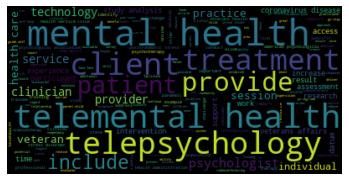

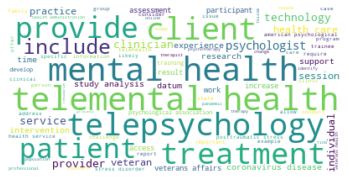

In [102]:
extra_words = ['et','al','need','eg','the','Johnson','use','this','in','s','\`','\_','\"','\-','e','g','\'','``']
from wordcloud import WordCloud
# Generate a word cloud image
#stopwords = ('')
wordcloud = WordCloud(stopwords=extra_words).generate(' '.join([w for w in df['Clean_Content'].values if len(w) > 1]))
# Display the generated image:
# the matplotlib way:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# lower max_font_size
wordcloud = WordCloud(stopwords=extra_words, max_font_size=40, background_color="white").generate(' '.join(df['Clean_Content'].values))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Pre-Covid

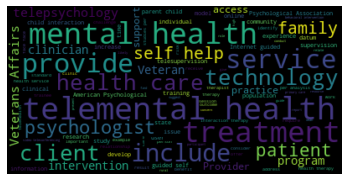

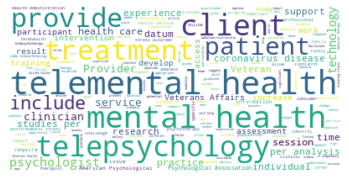

In [99]:
extra_words = ['et','al','need','eg','the','Johnson','use','this','in','s','\`','\_','\"','\-','e','g','\'','``']
from wordcloud import WordCloud
# Generate a word cloud image
#stopwords = ('')
wordcloud = WordCloud(stopwords=extra_words).generate(' '.join([w for w in Pre_Covid_df['Clean_Content'].values if len(w) > 1]))
# Display the generated image:
# the matplotlib way:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# lower max_font_size
wordcloud = WordCloud(stopwords=extra_words, max_font_size=40, background_color="white").generate(' '.join(df['Clean_Content'].values))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Covid

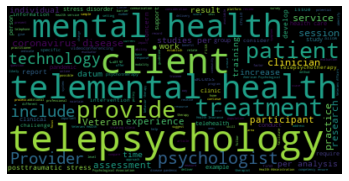

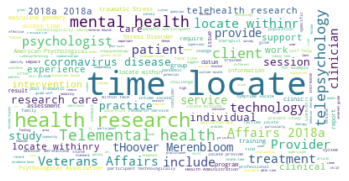

In [121]:
extra_words = ['et','al','need','eg','the','Johnson','use','this','in','s','\`','\_','\"','\-','e','g','\'','``']
from wordcloud import WordCloud
# Generate a word cloud image
#stopwords = ('')
wordcloud = WordCloud(stopwords=extra_words).generate(' '.join([w for w in Covid_df['Clean_Content'].values if len(w) > 1]))
# Display the generated image:
# the matplotlib way:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# lower max_font_size
wordcloud = WordCloud(stopwords=extra_words, max_font_size=40, background_color="white").generate(' '.join(df['Clean_Content'].values))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Freqentcy distribution for words
#### Overview

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



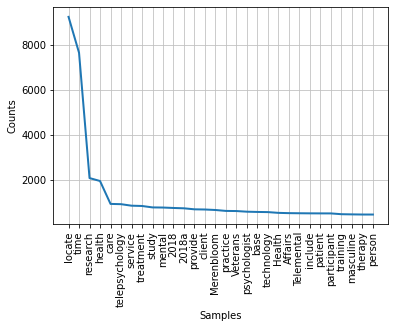

In [127]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
extra_words = ['et','al','need','eg','the','Johnson','use','this','in','s','\`','\_','\"','\-','e','g','\'','``','\)','\.','e\.g']

tokenized_word=word_tokenize(' '.join([w for w in df['Clean_Content'].values if len(w) > 1]))

  
filtered_sentence = [] 
  
for w in tokenized_word: 
    if len(w) > 1:
      filtered_sentence.append(w) 
  
filtered_sentence = [word for word in filtered_sentence if word not in extra_words]

print(tokenized_word) 
print(filtered_sentence) 

# Frequency Distribution
from nltk.probability import FreqDist
filtered_word_freq = FreqDist(filtered_sentence)

print(filtered_word_freq)

# Ten most common words
filtered_word_freq.most_common(10)

# Frequency Distribution Plots
import matplotlib.pyplot as plt
filtered_word_freq.plot(30,cumulative=False)
plt.show()

#### Pre-Covid

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


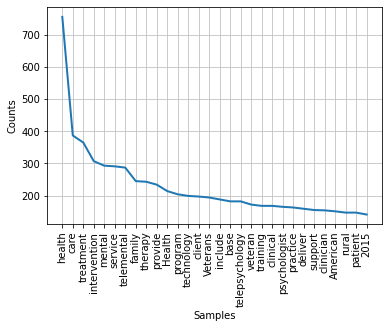

In [136]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
extra_words = ['et','al','need','eg','the','Johnson','use','this','in','s','\`','\_','\"','\-','e','g','\'','``','\)','\.','e\.g']

tokenized_word=word_tokenize(' '.join([w for w in Pre_Covid_df['Clean_Content'].values if len(w) > 1]))

  
filtered_sentence = [] 
  
for w in tokenized_word: 
    if len(w) > 1:
      filtered_sentence.append(w) 
  
filtered_sentence = [word for word in filtered_sentence if word not in extra_words]

#print(tokenized_word) 
#print(filtered_sentence) 

# Frequency Distribution
from nltk.probability import FreqDist
filtered_word_freq = FreqDist(filtered_sentence)

#print(filtered_word_freq)

# Ten most common words
filtered_word_freq.most_common(10)

# Frequency Distribution Plots
import matplotlib.pyplot as plt
filtered_word_freq.plot(30,cumulative=False)
plt.show()

#### Covid

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


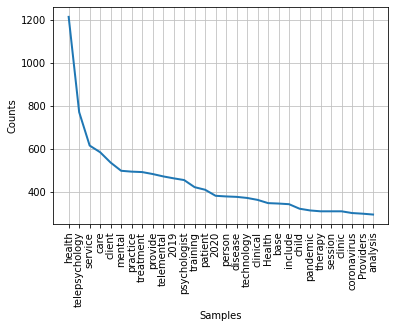

In [137]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
extra_words = ['et','al','need','eg','the','Johnson','use','this','in','s','\`','\_','\"','\-','e','g','\'','``','\)','\.','e.g']

tokenized_word=word_tokenize(' '.join([w for w in Covid_df['Clean_Content'].values if len(w) > 1]))

  
filtered_sentence = [] 
  
for w in tokenized_word: 
    if len(w) > 1:
      filtered_sentence.append(w) 
  
filtered_sentence = [word for word in filtered_sentence if word not in extra_words]

#print(tokenized_word) 
#print(filtered_sentence) 

# Frequency Distribution
from nltk.probability import FreqDist
filtered_word_freq = FreqDist(filtered_sentence)

#print(filtered_word_freq)

# Ten most common words
filtered_word_freq.most_common(10)

# Frequency Distribution Plots
import matplotlib.pyplot as plt
filtered_word_freq.plot(30,cumulative=False)
plt.show()

#Similarity analysis

In [108]:
import spacy
nlp = spacy.load('en_core_web_sm')
import warnings
warnings.filterwarnings("ignore")

#test the similarity between two texts
text_1 = nlp(df['Clean_Content'].values[0])
text_2 = nlp(df['Clean_Content'].values[2])
text_sim = text_1.similarity(text_2)
text_sim

In [110]:
similarity_array = np.zeros(shape=(len(df['Clean_Content']), len(df['Clean_Content'])))
for i in range(len(df['Clean_Content'])):          
    for j in range(len(df['Clean_Content'])):
        similarity_array[i][j] = nlp(df['Clean_Content'].values[i]).similarity(nlp(df['Clean_Content'].values[j]))

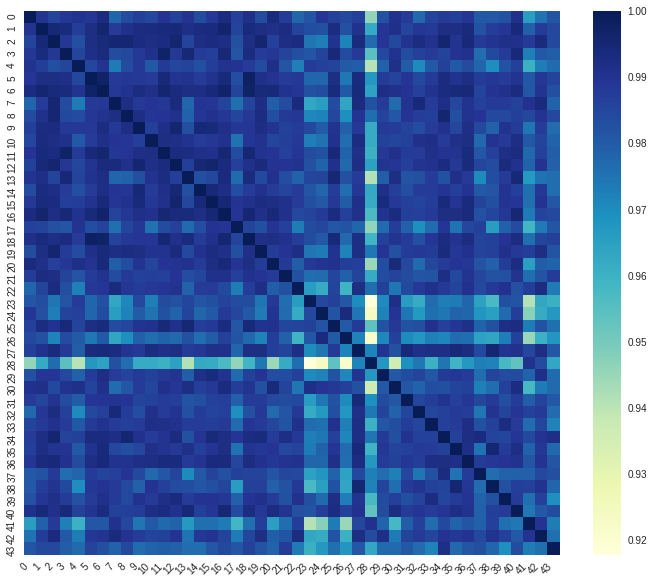

In [140]:
#https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
#https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,10))
ax = sns.heatmap(
    similarity_array,
    cmap="YlGnBu")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');